In [1]:
# Define functions to connect to Google and change directories
def connectDrive():
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

def changeDirectory(path):
    import os
    original_path = os.getcwd()
    os.chdir(path)
    new_path = os.getcwd()
    print("Original path: ",original_path)
    print("New path: ",new_path)

# Connect to Google Drive
connectDrive()

# Change path
changeDirectory("/content/drive/My Drive/github/find_p/")

Mounted at /content/drive
Original path:  /content
New path:  /content/drive/My Drive/github/find_p


In [2]:
!pip install vectorbt
!pip install pandas_ta
!pip install yfinance
!pip install plotly
!pip install numba
!apt-get install xvfb libgtk2.0-0 libgconf-2-4
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.7/485.7 KB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.4/293.4 KB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.8 MB/s eta 0:00:00
  Created wheel for vectorbt: filename=vectorbt-0.24.5-py3-none-any.whl size=526803 sha256=f73ded826be629e374715cbc8799215389b0b9ced8d094d210251fb0be728091
  Stored in directory: /root/.cache/pip/wheels/32/a8/75/4356ab56782d6ed50998d1c6d7798466dbc72aca9d8d5a4d9d
Successfully built vectorbt
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 KB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218923 sha256=aa6769304420

In [3]:
import numpy as np
import vectorbt as vbt
import pandas as pd
from hyperopt import fmin, tpe, hp
from hyperopt.pyll import scope
from datetime import datetime
from pdta_vt_utils import dl, dtmask

# Portfolio Setting

In [4]:
cheight, cwidth = 500, 1000 # Adjust as needed for Chart Height and Width
vbt.settings.set_theme("dark") # Options: "light" (Default), "dark" (my fav), "seaborn"

# Must be set
vbt.settings.portfolio["freq"] = "1D" # Daily

# Predefine vectorbt Portfolio settings
vbt.settings.portfolio["init_cash"] = 1000
vbt.settings.portfolio["fees"] = 0.0025 # 0.25%
vbt.settings.portfolio["slippage"] = 0.0025 # 0.25%
# vbt.settings.portfolio["size"] = 100
# vbt.settings.portfolio["accumulate"] = False
vbt.settings.portfolio["allow_partial"] = False

pf_settings = pd.DataFrame(vbt.settings.portfolio.items(), columns=["Option", "Value"])
pf_settings.set_index("Option", inplace=True)

print(f"Portfolio Settings [Initial]")
pf_settings

Portfolio Settings [Initial]


,Value
Option,
call_seq,default
init_cash,1000
size,inf
size_type,amount
fees,0.0025
fixed_fees,0.0
slippage,0.0025
reject_prob,0.0
min_size,0.0


# Data Collection

In [15]:
########################## You can change this ##################
# You can add any asset to the list, just add to the list the ticker you want to test
# you can also remove any ticker of the list

asset_tickers = ["AAPL", "TSLA", "TWTR", "SPXL", "^GSPC", "SPY"]
##################################################################

print("="*100)
print("Tickers by index #")
print(f"    Assets: {', '.join([f'{k}: {v}' for k,v in enumerate(asset_tickers)])}")
print("-"*100)
assets = dl(asset_tickers, lc_cols=True)

start_date = datetime(2010, 1, 1) # Adjust as needed
start_date = pd.to_datetime(start_date).tz_localize('America/New_York')
end_date = datetime(2015, 1, 1)   # Adjust as needed
end_date = pd.to_datetime(end_date).tz_localize('America/New_York')

print("="*100)
print("Available Data:")
print("="*100)
print(f"Assets: {', '.join(assets.keys())}")
print("="*100)


Tickers by index #
    Assets: 0: AAPL, 1: TSLA, 2: TWTR, 3: SPXL, 4: ^GSPC, 5: SPY
----------------------------------------------------------------------------------------------------
[i] Downloading: AAPL, TSLA, TWTR, SPXL, ^GSPC, SPY
[+] AAPL(10633, 7) Tuesday February 14, 2023, NYSE: 13:18:43
[+] TSLA(3180, 7) Tuesday February 14, 2023, NYSE: 13:18:43
[+] TWTR(2259, 7) Tuesday February 14, 2023, NYSE: 13:18:43
[+] SPXL(3592, 8) Tuesday February 14, 2023, NYSE: 13:18:44
[+] ^GSPC(23895, 7) Tuesday February 14, 2023, NYSE: 13:18:44
[+] SPY(7566, 8) Tuesday February 14, 2023, NYSE: 13:18:45
[*] Download Complete

Available Data:
Assets: AAPL, TSLA, TWTR, SPXL, ^GSPC, SPY


In [16]:
########### You need to set this #############################
# Numero del indice que se quiere ver e.j. spy i=5
asset_ind = 5 
##############################################################
asset_name = asset_tickers[3] # Change index for different symbol
print("="*100)
print(f"Selected Benchmark | Asset: {asset_name}")
print("="*100)

assetdf = assets[asset_name]

# Set True if you want to constrain Data between start_date & end_date
common_range = True
crs = ''
if common_range:
    crs = f" from {start_date} to {end_date}"
    assetdf = dtmask(assetdf, start_date, end_date)

# Update DataFrame names
assetdf.name = asset_name
print("="*100)
print(f"Analysis of:  {assetdf.name}{crs}")
print("="*100)

Selected Benchmark | Asset: SPXL
Analysis of:  SPXL from 2010-01-01 00:00:00-05:00 to 2015-01-01 00:00:00-05:00


In [17]:
assetdf

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2010-01-04 00:00:00-05:00,4.100748,4.207281,4.099988,4.200433,28238400,0.0,0.0,0.0
2010-01-05 00:00:00-05:00,4.195866,4.242284,4.147166,4.240001,33206400,0.0,0.0,0.0
2010-01-06 00:00:00-05:00,4.227826,4.278809,4.217934,4.251415,44194800,0.0,0.0,0.0
2010-01-07 00:00:00-05:00,4.229349,4.315336,4.188258,4.301639,43773600,0.0,0.0,0.0
2010-01-08 00:00:00-05:00,4.264352,4.352622,4.240001,4.347295,39685200,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2014-12-24 00:00:00-05:00,21.372375,21.452070,21.266897,21.290337,1291600,0.0,0.0,0.0
2014-12-26 00:00:00-05:00,21.445040,21.606775,21.421600,21.480200,2223200,0.0,0.0,0.0
2014-12-29 00:00:00-05:00,21.400508,21.634906,21.391132,21.559898,2677600,0.0,0.0,0.0


# Indicator Setting Use this section for custome indicators

In [18]:
# def wavetrend(high, low, close, n1, n2):
#     ap = (high + low + close) / 3.0  # HLC3
#     ap = pd.DataFrame(ap)
#     esa = ap.ewm(span=n1, adjust=False).mean()  # EMA
#     d = (abs(ap - esa)).ewm(span=n1, adjust=False).mean()
#     ci = (ap - esa) / (0.015 * d)
#     wt1 = ci.ewm(span=n2, adjust=False).mean()
#     wt2 = wt1.rolling(4).mean()
#     return wt1, wt2
#
#
# Wavetrend = vbt.IndicatorFactory(
#     class_name='Wavetrend',
#     input_names=['high', 'low', 'close'],
#     param_names=['n1', 'n2'],
#     output_names=['wt1', 'wt2'], ).from_apply_func(wavetrend)
#


# Optimization

In [19]:
below = 30,
above = 70


def optimize(params):
    # Parameters to optimize #
    fast, slow, signal, sl_stop = params
    #Indicator
    macd_ind = vbt.MACD.run(assetdf['Close'],
                            fast_window=fast,
                            slow_window=slow,
                            signal_window=signal)
    #strategy
    entries = macd_ind.macd_above(0) & macd_ind.macd_above(macd_ind.signal)
    exits = macd_ind.macd_below(0) | macd_ind.macd_below(macd_ind.signal)

    #portfolio
    pf = vbt.Portfolio.from_signals(close=assetdf['Close'], entries=entries, exits=exits, sl_stop=sl_stop, direction="longonly")

    print(f"total profit {pf.total_profit()} with parameters: {fast}, {slow}, {signal}, {sl_stop}")
    return np.array([pf.total_profit()])


def optimize_all(params):
    # optimization loss function (or objective function)
    res = optimize(params)
    return sum(res) * -1

# Search Space
sspace = [scope.int(hp.uniform('fast', 2, 51)),
         scope.int(hp.uniform('slow', 2, 51)),
         scope.int(hp.uniform('signal', 2, 21)),
         hp.uniform('sl_stop', 0.01, 0.1)]


# Optimization loop
best = fmin(optimize_all,
            space=sspace,
            algo=tpe.suggest,
            max_evals=100)

print(best)

total profit -299.90669722611824 with parameters: 50, 45, 14, 0.02186288168006676
total profit 320.4403917201331 with parameters: 41, 39, 6, 0.05912201628782722
total profit -772.0350658195965 with parameters: 9, 8, 4, 0.018058306951120165
total profit -526.4887471319851 with parameters: 3, 12, 8, 0.03573134089670841
total profit 241.22517823012686 with parameters: 21, 6, 5, 0.02940302805782355
total profit -474.33690705275035 with parameters: 47, 4, 2, 0.01640014342788676
total profit -184.10949751533497 with parameters: 24, 48, 11, 0.036520502453513966
total profit 331.01483749874797 with parameters: 19, 33, 19, 0.06488463088191614
total profit -67.48946067874033 with parameters: 19, 47, 20, 0.06657824380735139
total profit -372.8340582321596 with parameters: 27, 45, 4, 0.07824012059789108
total profit -454.5987211934781 with parameters: 27, 45, 8, 0.04745085966793326
total profit 3124.5655907526257 with parameters: 38, 23, 12, 0.014349072408091516
total profit -72.14652091441928 wit

In [20]:
### Use the results from the optimization to prepare an optimal portfolio
# Just copy/paste the values or aproximate then to an integer
########################################
fast = 39 #math.ceil(best['k_window'])
signal = 14 #math.ceil(best['d_window'])
slow = 22 #math.ceil(best['d_ewm'])
sl_stop = best['sl_stop']

In [21]:
macd_ind = vbt.MACD.run(assetdf['Close'],
                            fast_window=fast,
                            slow_window=slow,
                            signal_window=signal)

entries = macd_ind.macd_above(0) & macd_ind.macd_above(macd_ind.signal)
exits = macd_ind.macd_below(0) | macd_ind.macd_below(macd_ind.signal)

pf = vbt.Portfolio.from_signals(close=assetdf['Close'],
                                entries=entries,
                                exits=exits,
                                sl_stop=sl_stop,
                                direction="longonly")

pf.stats()

Start                          2010-01-04 00:00:00-05:00
End                            2014-12-31 00:00:00-05:00
Period                                1258 days 00:00:00
Start Value                                       1000.0
End Value                                    4174.120385
Total Return [%]                              317.412039
Benchmark Return [%]                          389.505782
Max Gross Exposure [%]                             100.0
Total Fees Paid                               289.562765
Max Drawdown [%]                               24.865524
Max Drawdown Duration                  396 days 00:00:00
Total Trades                                          29
Total Closed Trades                                   29
Total Open Trades                                      0
Open Trade PnL                                       0.0
Win Rate [%]                                    58.62069
Best Trade [%]                                 27.212121
Worst Trade [%]                

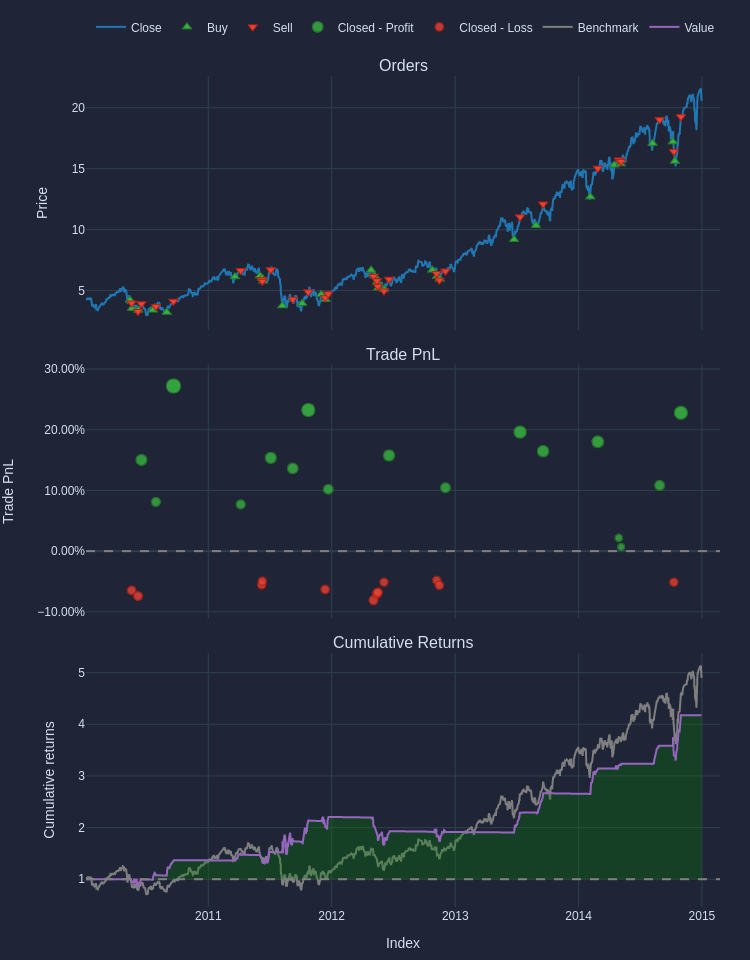

In [22]:
pf.plot().show_png()

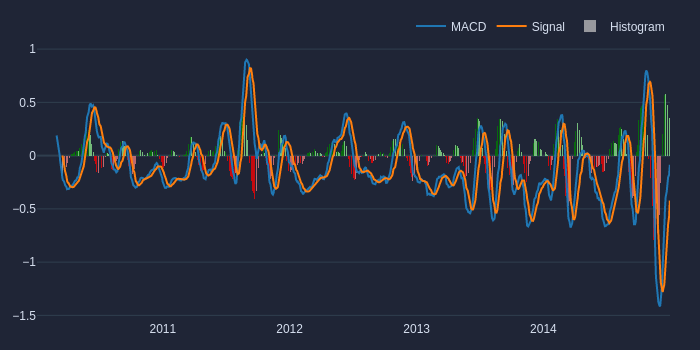

In [23]:
macd_ind.plot().show_png()